In [1]:
import pandas as pd

# Load datasets
true_df = pd.read_csv(r'C:\Users\M Sarmad Usman\Desktop\News detection\data\True.csv')
fake_df = pd.read_csv(r'C:\Users\M Sarmad Usman\Desktop\News detection\data\Fake.csv')

# Add labels
true_df['label'] = 1  # Real
fake_df['label'] = 0  # Fake

# Combine datasets
df = pd.concat([true_df, fake_df], ignore_index=True)

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check data
print("✅ Dataset loaded and combined!")
print("📊 Shape:", df.shape)
print(df[['text', 'label']].head())


✅ Dataset loaded and combined!
📊 Shape: (44898, 5)
                                                text  label
0  Donald Trump s White House is in chaos, and th...      0
1  Now that Donald Trump is the presumptive GOP n...      0
2  Mike Pence is a huge homophobe. He supports ex...      0
3  SAN FRANCISCO (Reuters) - California Attorney ...      1
4  Twisted reasoning is all that comes from Pelos...      0


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')

# Fit and transform the text data
X = tfidf_vectorizer.fit_transform(df['text'])

# Target labels
y = df['label']

# Check the shape of your feature matrix
print("TF-IDF matrix shape:", X.shape)


TF-IDF matrix shape: (44898, 10000)


In [3]:
from sklearn.model_selection import train_test_split

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")


Train size: 35918, Test size: 8980


In [4]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
lr_model.fit(X_train, y_train)

print("✅ Logistic Regression model trained!")


✅ Logistic Regression model trained!


✅ Accuracy:  0.9872
✅ Precision: 0.9826
✅ Recall:    0.9907
✅ F1 Score:  0.9866

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



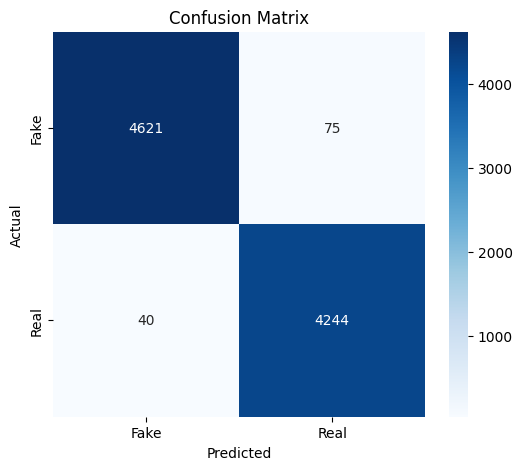

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions on test set
y_pred = lr_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1 Score:  {f1:.4f}\n")

# Detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [6]:
import joblib

# Save the trained Logistic Regression model
joblib.dump(lr_model, 'logistic_regression_model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

print("✅ Model and vectorizer saved!")


✅ Model and vectorizer saved!


In [7]:
# Load model and vectorizer
loaded_model = joblib.load('logistic_regression_model.pkl')
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Sample new text input
new_text = ["Breaking news: The government just passed a new law"]

# Preprocess and vectorize
new_text_tfidf = loaded_vectorizer.transform(new_text)

# Predict
prediction = loaded_model.predict(new_text_tfidf)
prediction_prob = loaded_model.predict_proba(new_text_tfidf)

print(f"Prediction: {'Real' if prediction[0] == 1 else 'Fake'}")
print(f"Confidence: {max(prediction_prob[0]) * 100:.2f}%")


Prediction: Fake
Confidence: 95.49%


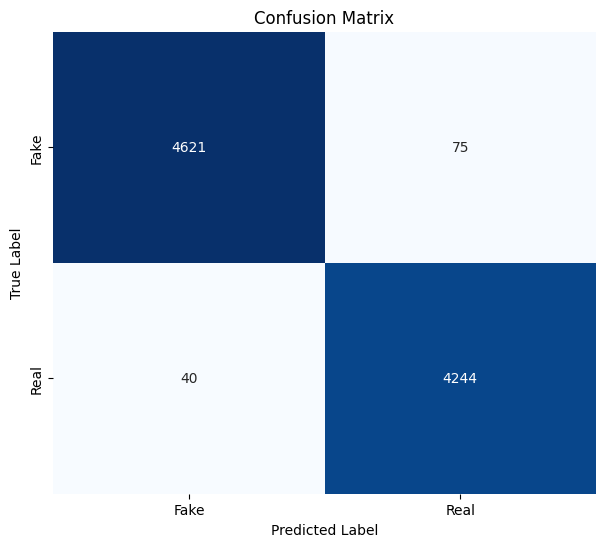

Model Accuracy: 0.9872

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



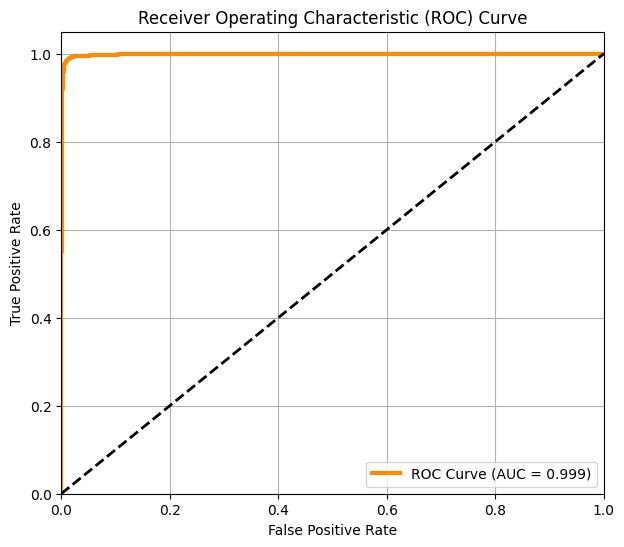

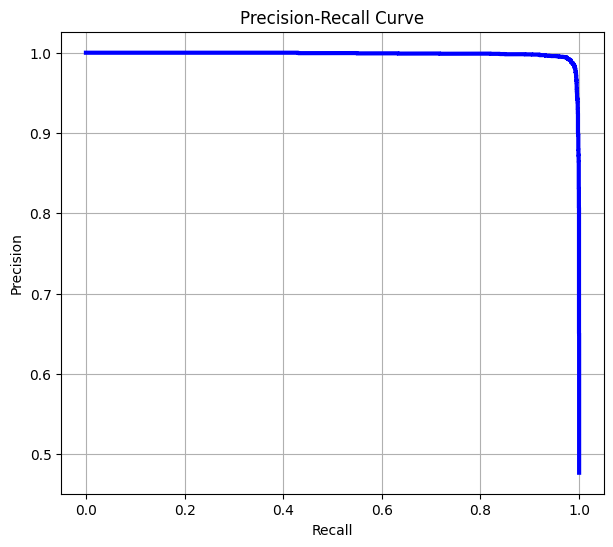

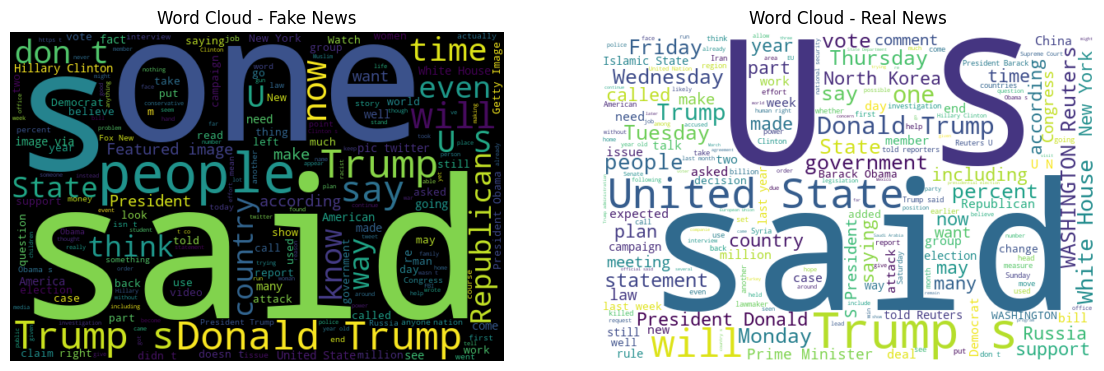

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# 1. Plot Confusion Matrix with better design
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'], cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 2. Print classification report with summary metrics upfront
report = classification_report(y_test, y_pred, output_dict=True)
accuracy = report['accuracy']
precision_fake = report['0']['precision']
recall_fake = report['0']['recall']
f1_fake = report['0']['f1-score']
precision_real = report['1']['precision']
recall_real = report['1']['recall']
f1_real = report['1']['f1-score']

print(f"Model Accuracy: {accuracy:.4f}\n")
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred))

# 3. ROC Curve
y_prob = lr_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', color='darkorange', linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 4. Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(7,6))
plt.plot(recall, precision, color='blue', linewidth=3)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# 5. WordCloud for most common words in Fake and Real news
fake_text = ' '.join(df[df['label'] == 0]['text'].values)
real_text = ' '.join(df[df['label'] == 1]['text'].values)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
wc_fake = WordCloud(width=600, height=400, background_color='black').generate(fake_text)
plt.imshow(wc_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Fake News')

plt.subplot(1,2,2)
wc_real = WordCloud(width=600, height=400, background_color='white').generate(real_text)
plt.imshow(wc_real, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Real News')

plt.show()


In [9]:
import joblib

# Save the Logistic Regression model
joblib.dump(lr_model, 'lr_model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [10]:
import joblib

lr_model = joblib.load('lr_model.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
